# Volumetric properties of binary mixtures
---
Written by: Dr. Nebojša Zec (Mr.)  
German Engineering Materials Science Centre (GEMS) at Heinz Maier-Leibnitz Zentrum (MLZ)  
Helmholtz Zentrum Hereon GmbH  
Lichtenbergstr. 1, 81748 Garching bei München, Germany  
<nebojsa.zec@hereon.de>  
For the questions regarding this script write to:  
<nebojsa.zec@yahoo.com>

---

### Purpose
This Jupyter Notebook can be used to quickly and easily calculate volumetric properties of **binary** liquid mixtures:  
 - Excess molar volume (including Redlich-Kister fitting)
 - Partial molar volume
 - Apparent molar volume
 - (Excess) isobaric thermal expansion coefficients

>Some detailed explanations are given along the way for those inexperienced in python and/or jupyer notebooks.

### What is required?

A .txt file containing the density data of binary mixtures and pure components at one or more different temperatures.
Molar masses of the components.

As an input, one has to provide a .txt file with the experimental (or simulated) density data in g$\cdot$cm$^{-3}$ at one or more different temperatures. 
The .txt file has to be formated in the following way:
 - The first row (header) includes x$_1$ and temperatures at which density was measured (one or more temperatures) in the format **xxx.xx K** - everything separated by **"Tab"-s**.
 - The first column has to be molar fraction (x$_1$) of the component 1. 
 - Other columns contain measured density data (in g$\cdot$cm$^{-3}$). In the example data_example.txt there are densities at 7 different temperatures. 
 - Densities of the pure component 1 (x$_1$ = 1) and component 2 (x$_1$ = 0) have to be included in the table!
 - One can use my **data_example.txt** as a template.
 - **All the values in the .txt should be separated by "Tab"!**
 
These are the data contained in data_example.txt:

| x1 | 273.15 K | 283.15 K | 293.15 K | 298.15 K | 303.15 K | 313.15 K | 323.15 K
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: |
|0.000000 |	1.149155 | 1.139314 | 1.129493 | 1.124588 |	1.119684 | 1.109874 | 1.100053 
|0.098731 | 1.124753 | 1.116136 | 1.107563 | 1.103289 |	1.099021 | 1.090512 | 1.082021
|0.185857 | 1.107123 | 1.099190 | 1.091307 | 1.087383 |	1.083471 | 1.075667 | 1.067900 
|0.302947 | 1.087909 | 1.080611 | 1.073370 | 1.069767 |	1.066180 | 1.059035 | 1.051931
|0.498470 | 1.063962 | 1.057342 | 1.050781 | 1.047527 |	1.044281 | 1.037833 | 1.031434
|0.695415 | 1.046525 | 1.040350 | 1.034233 | 1.031193 |	1.028171 | 1.022161 | 1.016250
|0.901334 | 1.032968 | 1.027116 | 1.021315 | 1.018433 |	1.015566 | 1.009872 | 1.004229
|1.000000 | 1.027694 | 1.021962 | 1.016277 | 1.013449 |	1.010638 | 1.005058 | 0.999525 

### What comes as an output?

As an output in the working directory user gets a volumetric_properties.csv - file containing all the calculated volumetric properties - and figures in .pdf format (or .jpg, .png) 

---

**1. Step: Import relevant packages**  
These are the libraries used in this script, this step doesn't require input from the user.  
***Notes:***  
If the python on your PC is installed as Anaconda distribution, all of these packages are included in it.
Otherwise, an error in this step can mean that you have to install some package.  
In terminal:

> pip install package-name  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import linregress

**2. Step: Define molar mass of the components and name of your .txt file that contains density data**  
 - Molar mass (M$_1$ and M$_2$) of components 1 and 2 in g/mol   
 - If your denisty data file is in the same directory as this script - specify the name under quotations. Otherwise specify the path to the file.
 - By default script will save all the volumetric properties in a .csv file in your working directory, as well as graphs as .pdf files. If you don't want this change save_data_to_csv or save_figures to "no". Pay attetion that each time you run the script these files will be overwritten.

In [2]:
#Molar mass of liquids
M1 = 208.303882
M2 = 86.089398

#Instead of data_example.txt give the file name or the path to your .txt file
file_data = "data_example.txt"

#save_data_to_csv could be "yes" or "no"
save_data_to_csv = "yes"

#save_figures could be "no" or "pdf", "jpg", "png"...
save_figures = "pdf"

**Step 3. Define the Redlich-Kister and polynomial equations for fitting the excess volumes and calculating partial molar volumes.**

You can simply change the order of RK polynomial

This is the 3rd order RK equation and is by "default" in this script.  
$y = x_1 \cdot (1-x_1) \cdot (A_1 + A_2 \cdot (2x_1 - 1) + A_3 \cdot (2x_1 - 1)^2)$  

The 5th order would be:  
$y = x_1 \cdot (1-x_1) \cdot (A_1 + A_2 \cdot (2x_1 - 1) + A_3 \cdot (2x_1 - 1)^2 + A_4 \cdot (2x_1 - 1)^3)+ A_5 \cdot (2x_1 - 1)^4)$  
and the function would be:

>       def Redlich_Kister(x, A1, A2, A3, A4, A5):
>           y = x*(1-x)*(A1+A2*(2*x-1)+A3*(2*x-1)**2 + A4*(2*x-1)**3 + A5*(2*x-1)**4)
>           return y


When you change the order of Redlich_Kister polynome to Xth order, change the Polynom and Polynom_2 functions to Xth+1 order. These are used for the calculation of partial molar volumes

In [6]:
def Redlich_Kister(x, A1, A2, A3):
    y = x*(1-x)*(A1+A2*(2*x-1)+A3*(2*x-1)**2)
    return y
    
def Polynom(x, a1, a2, a3, a4):
    y = a1*x + a2*x**2 + a3*x**3 + a4*x**4
    return y

def Polynom_2(x, a1, a2, a3, a4):
    y = 1*a1 + 2*a2*x + 3*a3*x**2 + 4*a4*x**3
    return y


#def polinomial(x, a1, a2, a3, a4):
#    y = a1 + a2*x + a3*x**2 + a4*x**3
#    return y

***Step 4. Extract the data from the .txt file***  
In this step mole fraction and density data are extracted from the .txt file and some needed quantities are calculated (molar volumes of pure components and molality-used for calculating apparent molar volumes).
The table is shown for a visual inspection of the imported data.

No input from user needed

In [7]:
#reading the expreimental data from the specified txt file 
data = pd.read_csv(file_data, sep = '\t', header = 0, index_col=False)

#extract molar fraction of component 1 (IL in this case)
x1 = np.array(data[data.columns[0]])

#calculate molality of components - these will be needed for apparent molar volumes
b1 = x1[1:-1]/(M2*(1-x1[1:-1]))
b2 = (1-x1[1:-1])/(M1*x1[1:-1])

#extract density values at different temperatures
d = {}
for i in range(1,len(data.columns)):
    d["d{0}".format(data.columns[i])] = np.array(data[data.columns[i]])

#extract density of pure components at different temperatures
d1_pure = []
for i in d.values():
    d1_pure.append(i[-1])
d1_pure = np.array(d1_pure)

d2_pure = []
for i in d.values():
    d2_pure.append(i[0])
d2_pure = np.array(d2_pure)   

#calculate molar volumes of pure liquids
V1_pure = M1/d1_pure
V2_pure = M2/d2_pure

#show the imported data for inspection
pd.DataFrame(data)

x1  273.15 K  283.15 K  293.15 K  298.15 K  303.15 K  313.15 K  \
0  0.000000  1.149155  1.139314  1.129493  1.124588  1.119684  1.109874   
1  0.098731  1.124753  1.116136  1.107563  1.103289  1.099021  1.090512   
2  0.185857  1.107123  1.099190  1.091307  1.087383  1.083471  1.075667   
3  0.302947  1.087909  1.080611  1.073370  1.069767  1.066180  1.059035   
4  0.498470  1.063962  1.057342  1.050781  1.047527  1.044281  1.037833   
5  0.695415  1.046525  1.040350  1.034233  1.031193  1.028171  1.022161   
6  0.901334  1.032968  1.027116  1.021315  1.018433  1.015566  1.009872   
7  1.000000  1.027694  1.021962  1.016277  1.013449  1.010638  1.005058   

   323.15 K  
0  1.100053  
1  1.082021  
2  1.067900  
3  1.051931  
4  1.031434  
5  1.016250  
6  1.004229  
7  0.999525

In [9]:
'''
CALCULATE VE

'''
Ve = {}

for i in range(1, len(data.columns)):
    Ve["Ve-{0}".format(data.columns[i])] = x1*(M1/list(d.values())[i-1] - M1/d1_pure[i-1]) + (1-x1)*(M2/list(d.values())[i-1] - M2/d2_pure[i-1])

RK_parameters = []
r_sq = []
for i in Ve.values():
    pars, covs = curve_fit(Redlich_Kister, x1, i)
    RK_parameters.append(pars)
    
    #The residual sum of squares (ss_res):

    residuals = i - Redlich_Kister(x1, *pars)
    ss_res = np.sum(residuals**2)

    #The total sum of squares (ss_tot) with

    ss_tot = np.sum((i-np.mean(i))**2)

    #The r_squared-value
    r_squared = 1 - (ss_res / ss_tot)
    r_sq.append(r_squared)

    
x_fit = np.linspace(0, 1, 100)
VE_fit = []

for i in range(0, len(RK_parameters)):
    fit_y = Redlich_Kister(x_fit, RK_parameters[i][0], RK_parameters[i][1], RK_parameters[i][2])
    VE_fit.append(fit_y)
        
'''
CALCULATE PARTIAL MOLAR VOLUMES
'''    
polynom_parameters = []

for i in Ve.values():
    pars, covs = curve_fit(Polynom, x1, i)
    polynom_parameters.append(pars)

dmV1 = []
dmV2 = []
V1_part = []
V2_part = []

for i,j,k in zip(polynom_parameters, V1_pure, V2_pure):
    y1 = Polynom(x1, i[0], i[1], i[2], i[3])
    y2 = Polynom_2(x1, i[0], i[1], i[2], i[3])

    dmV1.append(y1+(1-x1)*y2)
    dmV2.append(y1-x1*y2)

    V1_part.append(j + y1+(1-x1)*y2)
    V2_part.append(k + y1-x1*y2)

'''
CALCULATE APPARENT MOLAR VOLUMES, THERMAL COEFFITIENTS
'''    
#Extract temperatures form the data (The temperatures must be in the form 273.15 K!!!)
temperature = []
for i in np.array(data.columns[1:len(data.columns)]):
    temperature.append(float((i[:6])))

#Extract density    
density = np.array(data[data.columns[1:8]])

#Linear fit of the density with temperature

slope = []
intercept = []
rvalue = []
stderr = []

for i in density:
    a = linregress(temperature, i)
    slope.append(a.slope)
    intercept.append(a.intercept)
    rvalue.append(a.rvalue)
    stderr.append(a.stderr)
    

therm_exp_coeff = []
for i,j in zip(density, slope):
    therm_exp_coeff.append(-1/i*j)
therm_exp_coeff = np.transpose(therm_exp_coeff) 

volume_fraction = []
for i,j in zip(V1_pure, V2_pure):
    volume_fraction.append(x1*i/(x1*i+(1-x1)*j))
    
excess_therm_exp_coeff = []
for i,j in zip(therm_exp_coeff,volume_fraction):
    excess_therm_exp_coeff.append(i-(j*i[-1]+(1-j)*i[0]))
    
apparent_molar_volumes_1 = []
for i in np.transpose(density):
    apparent_molar_volumes_1.append((i[0]-i[1:-1])/(b1*i[1:-1]*i[0])+M1/i[1:-1])
    
apparent_molar_volumes_2 = []
for i in np.transpose(density):
    apparent_molar_volumes_2.append((i[-1]-i[1:-1])/(b2*i[1:-1]*i[-1])+M2/i[1:-1])

    


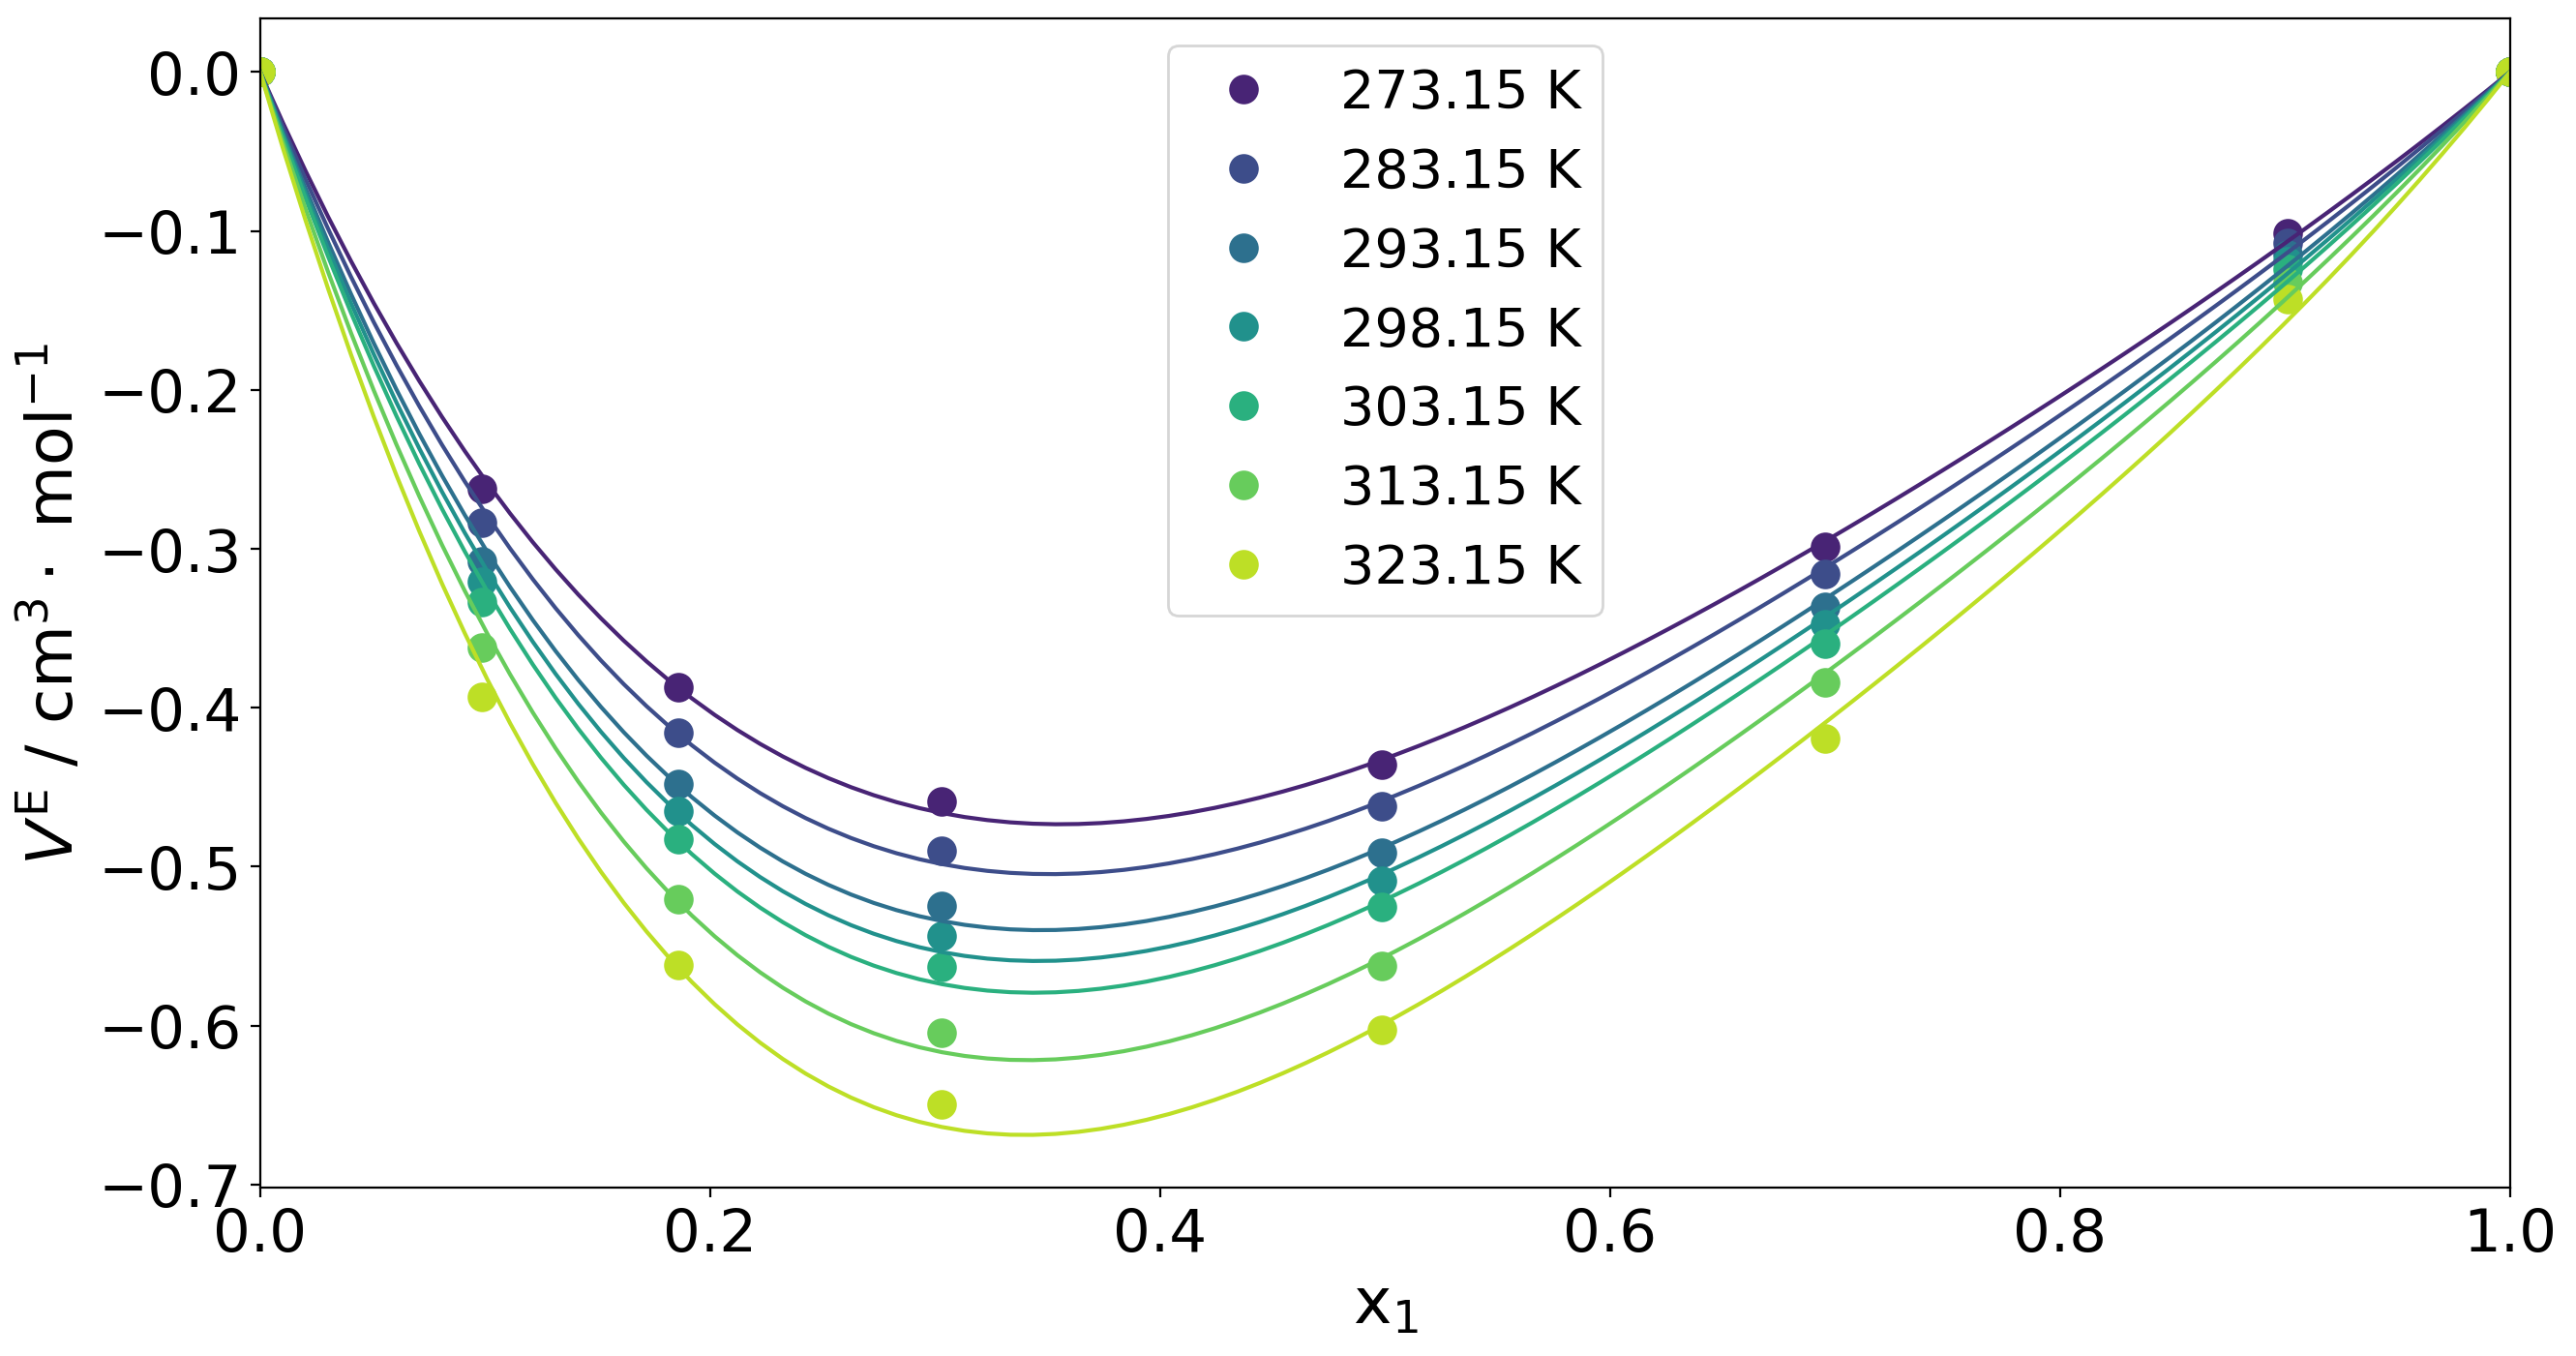

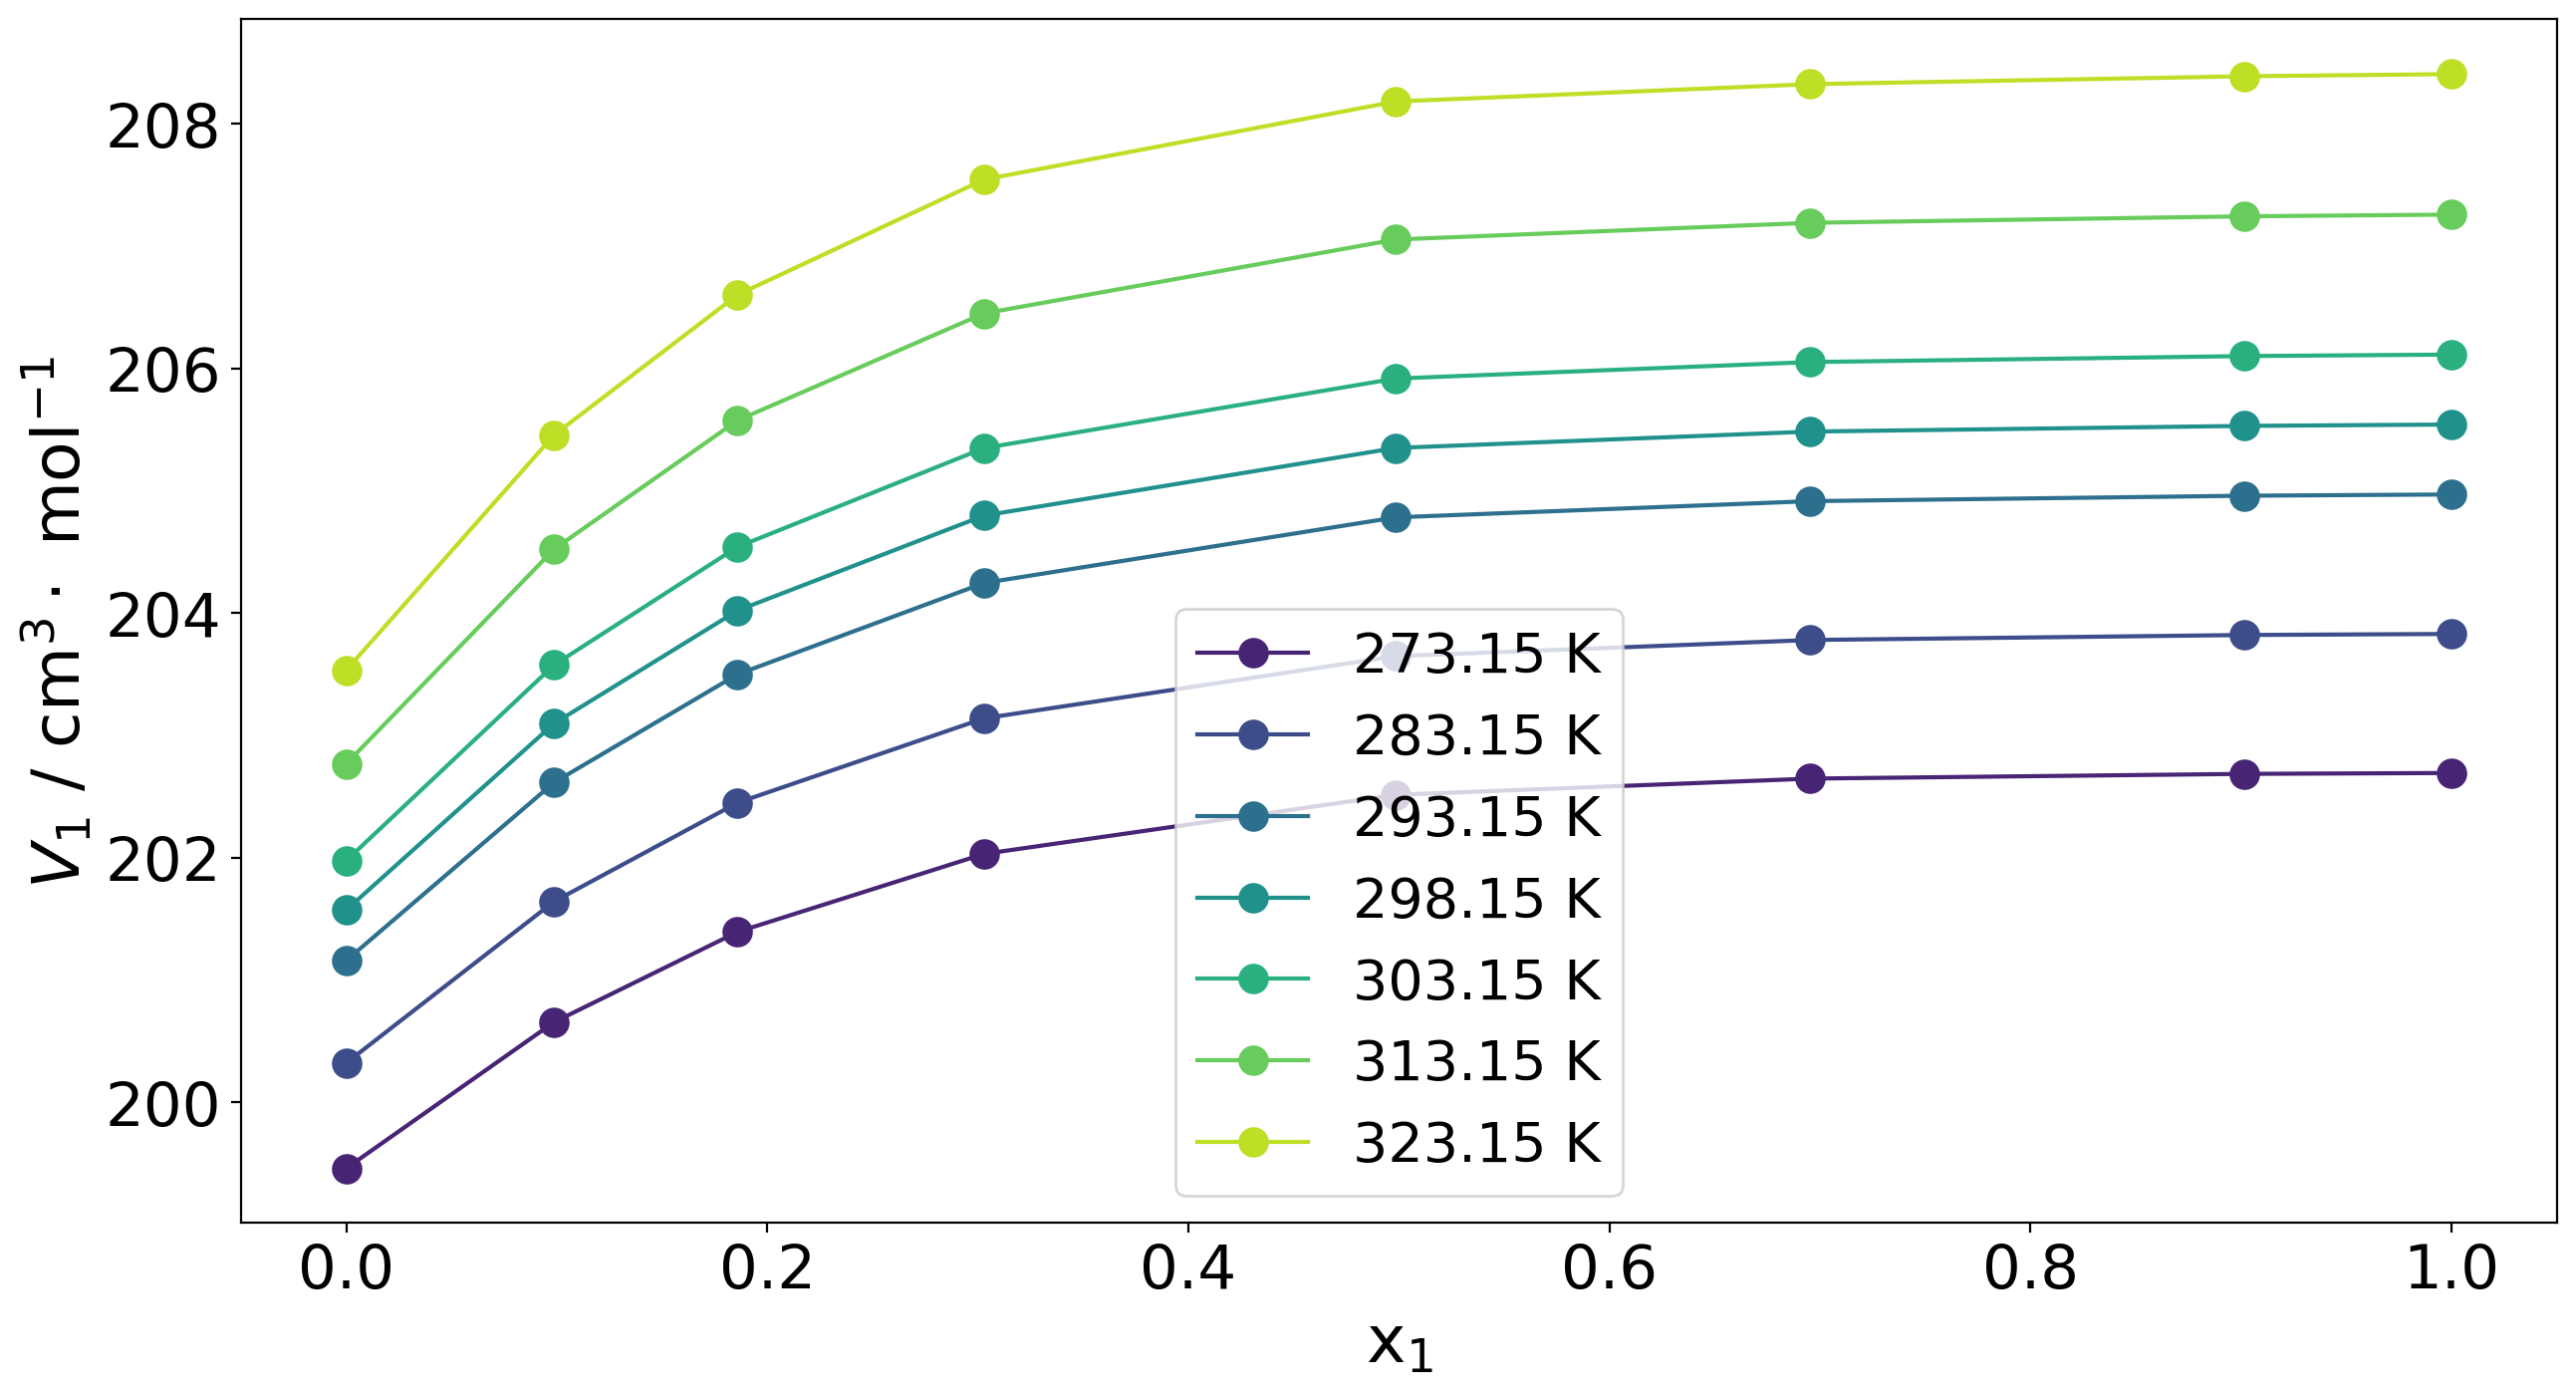

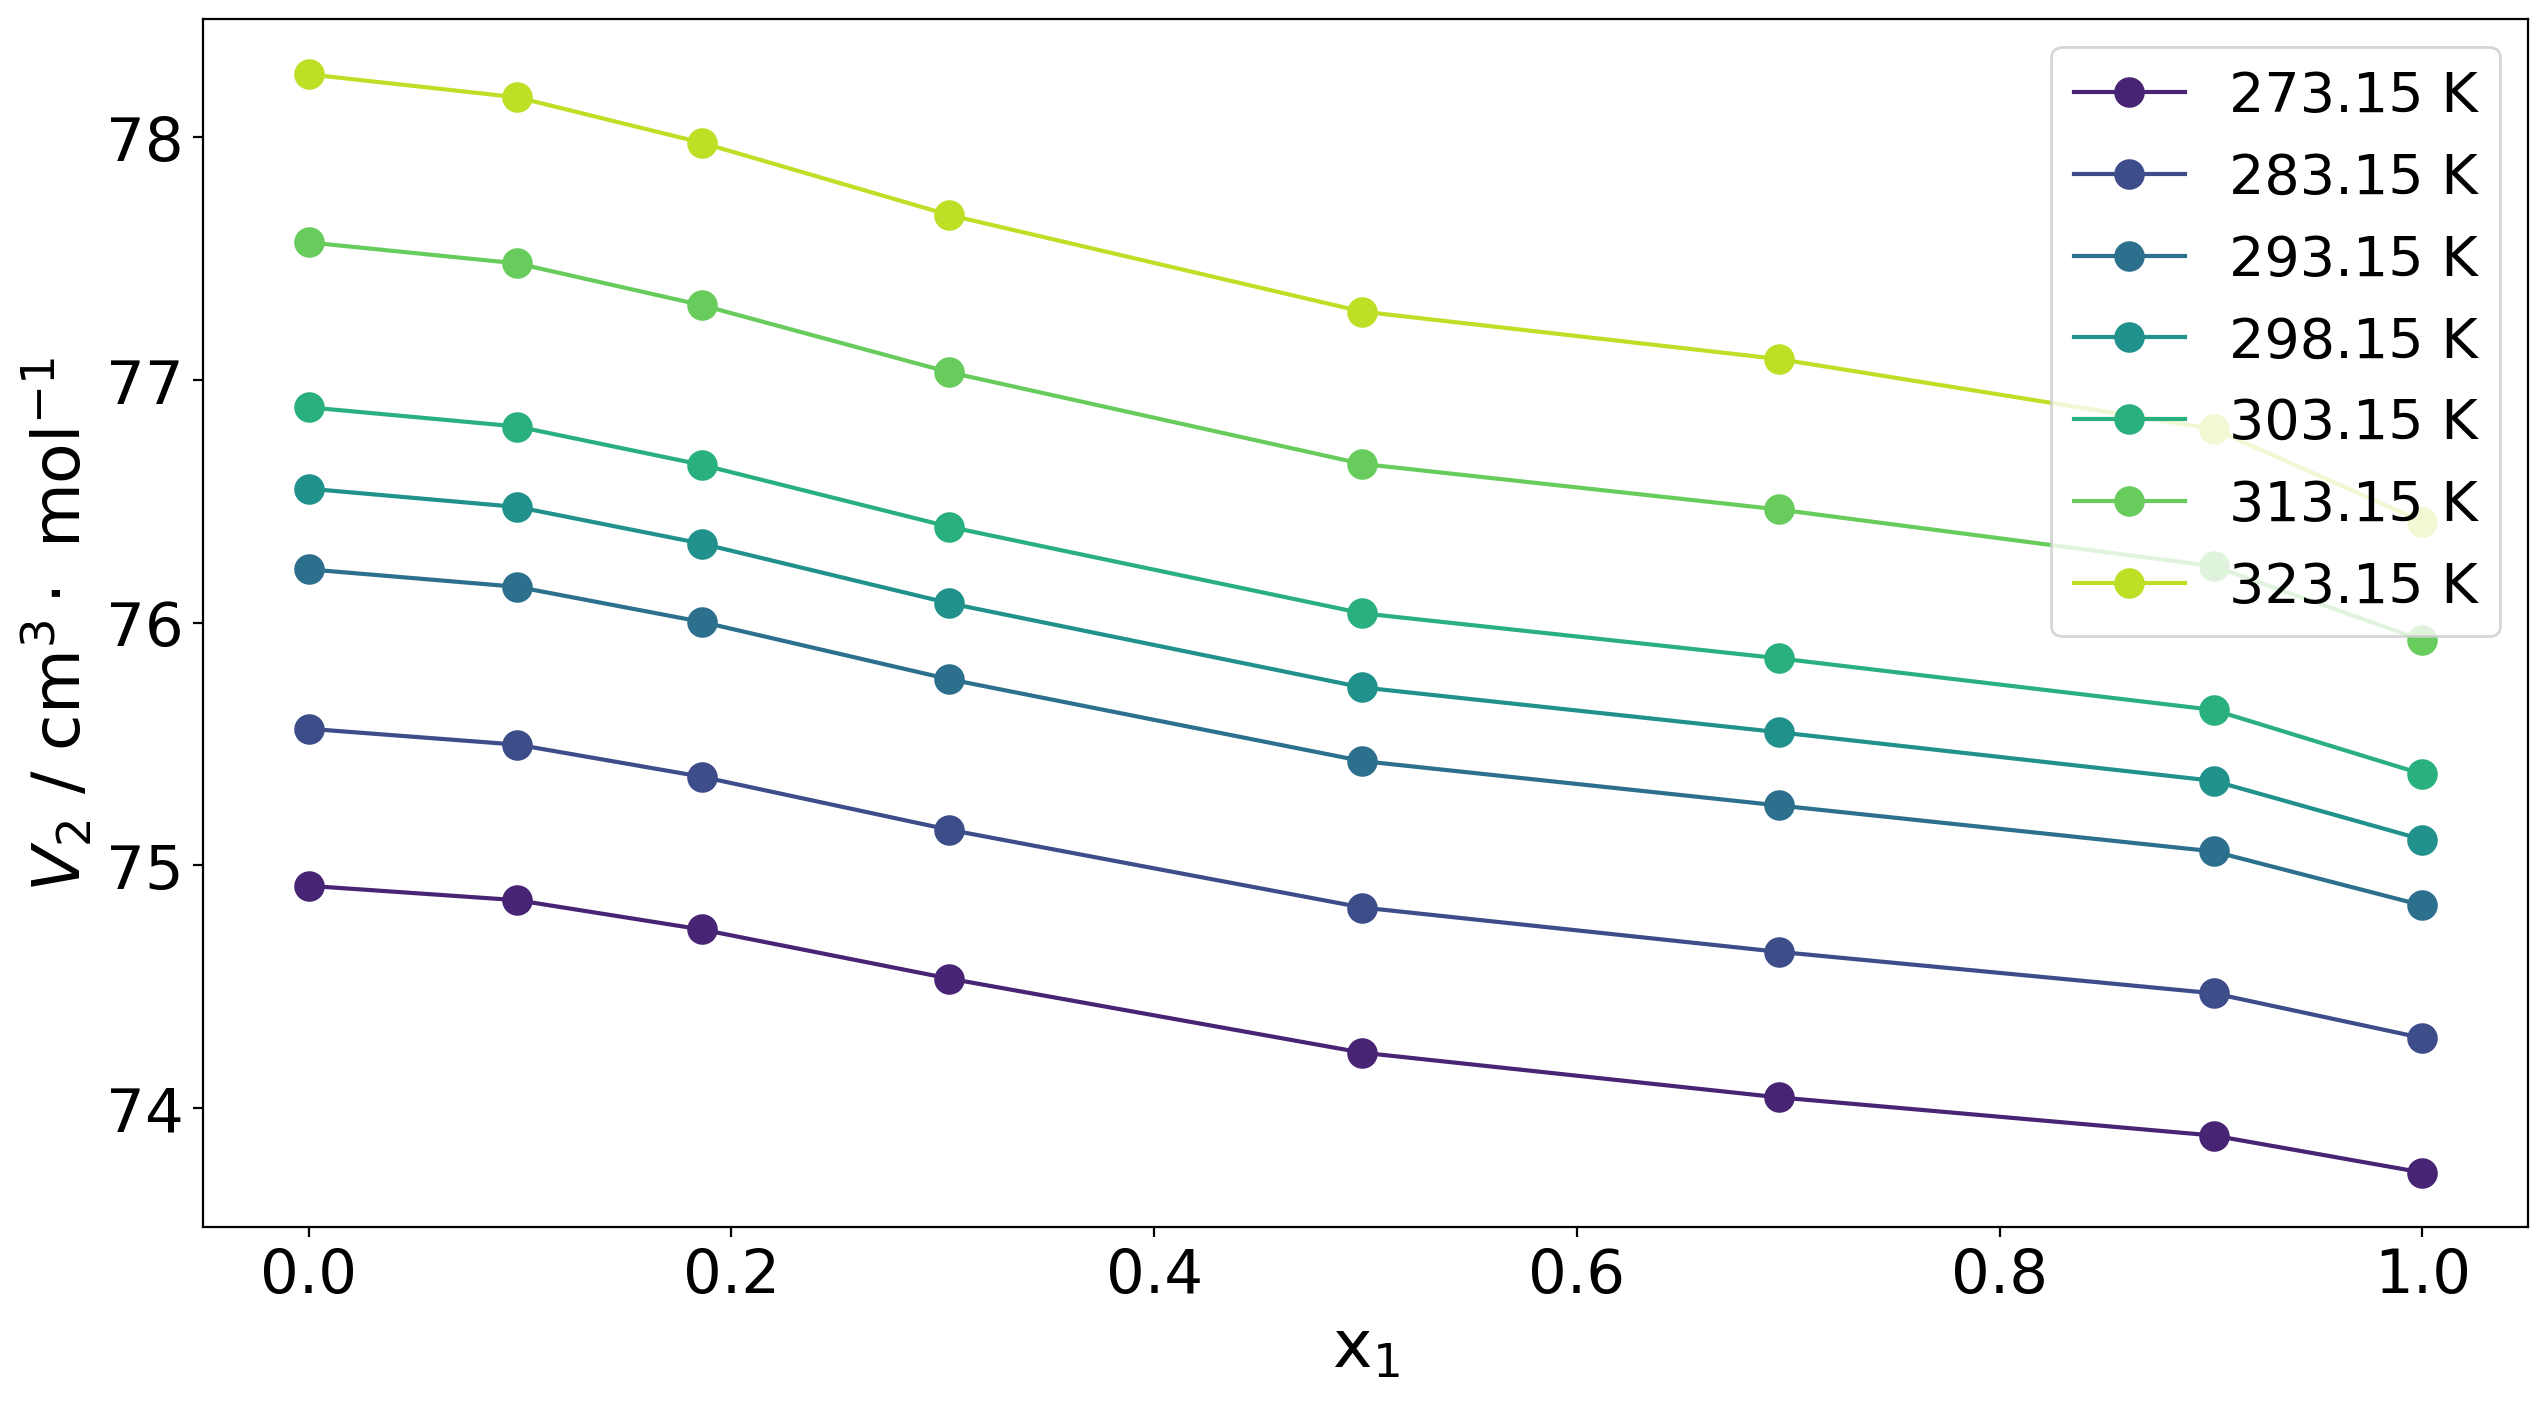

APPARENT MOLAR VOLUMES


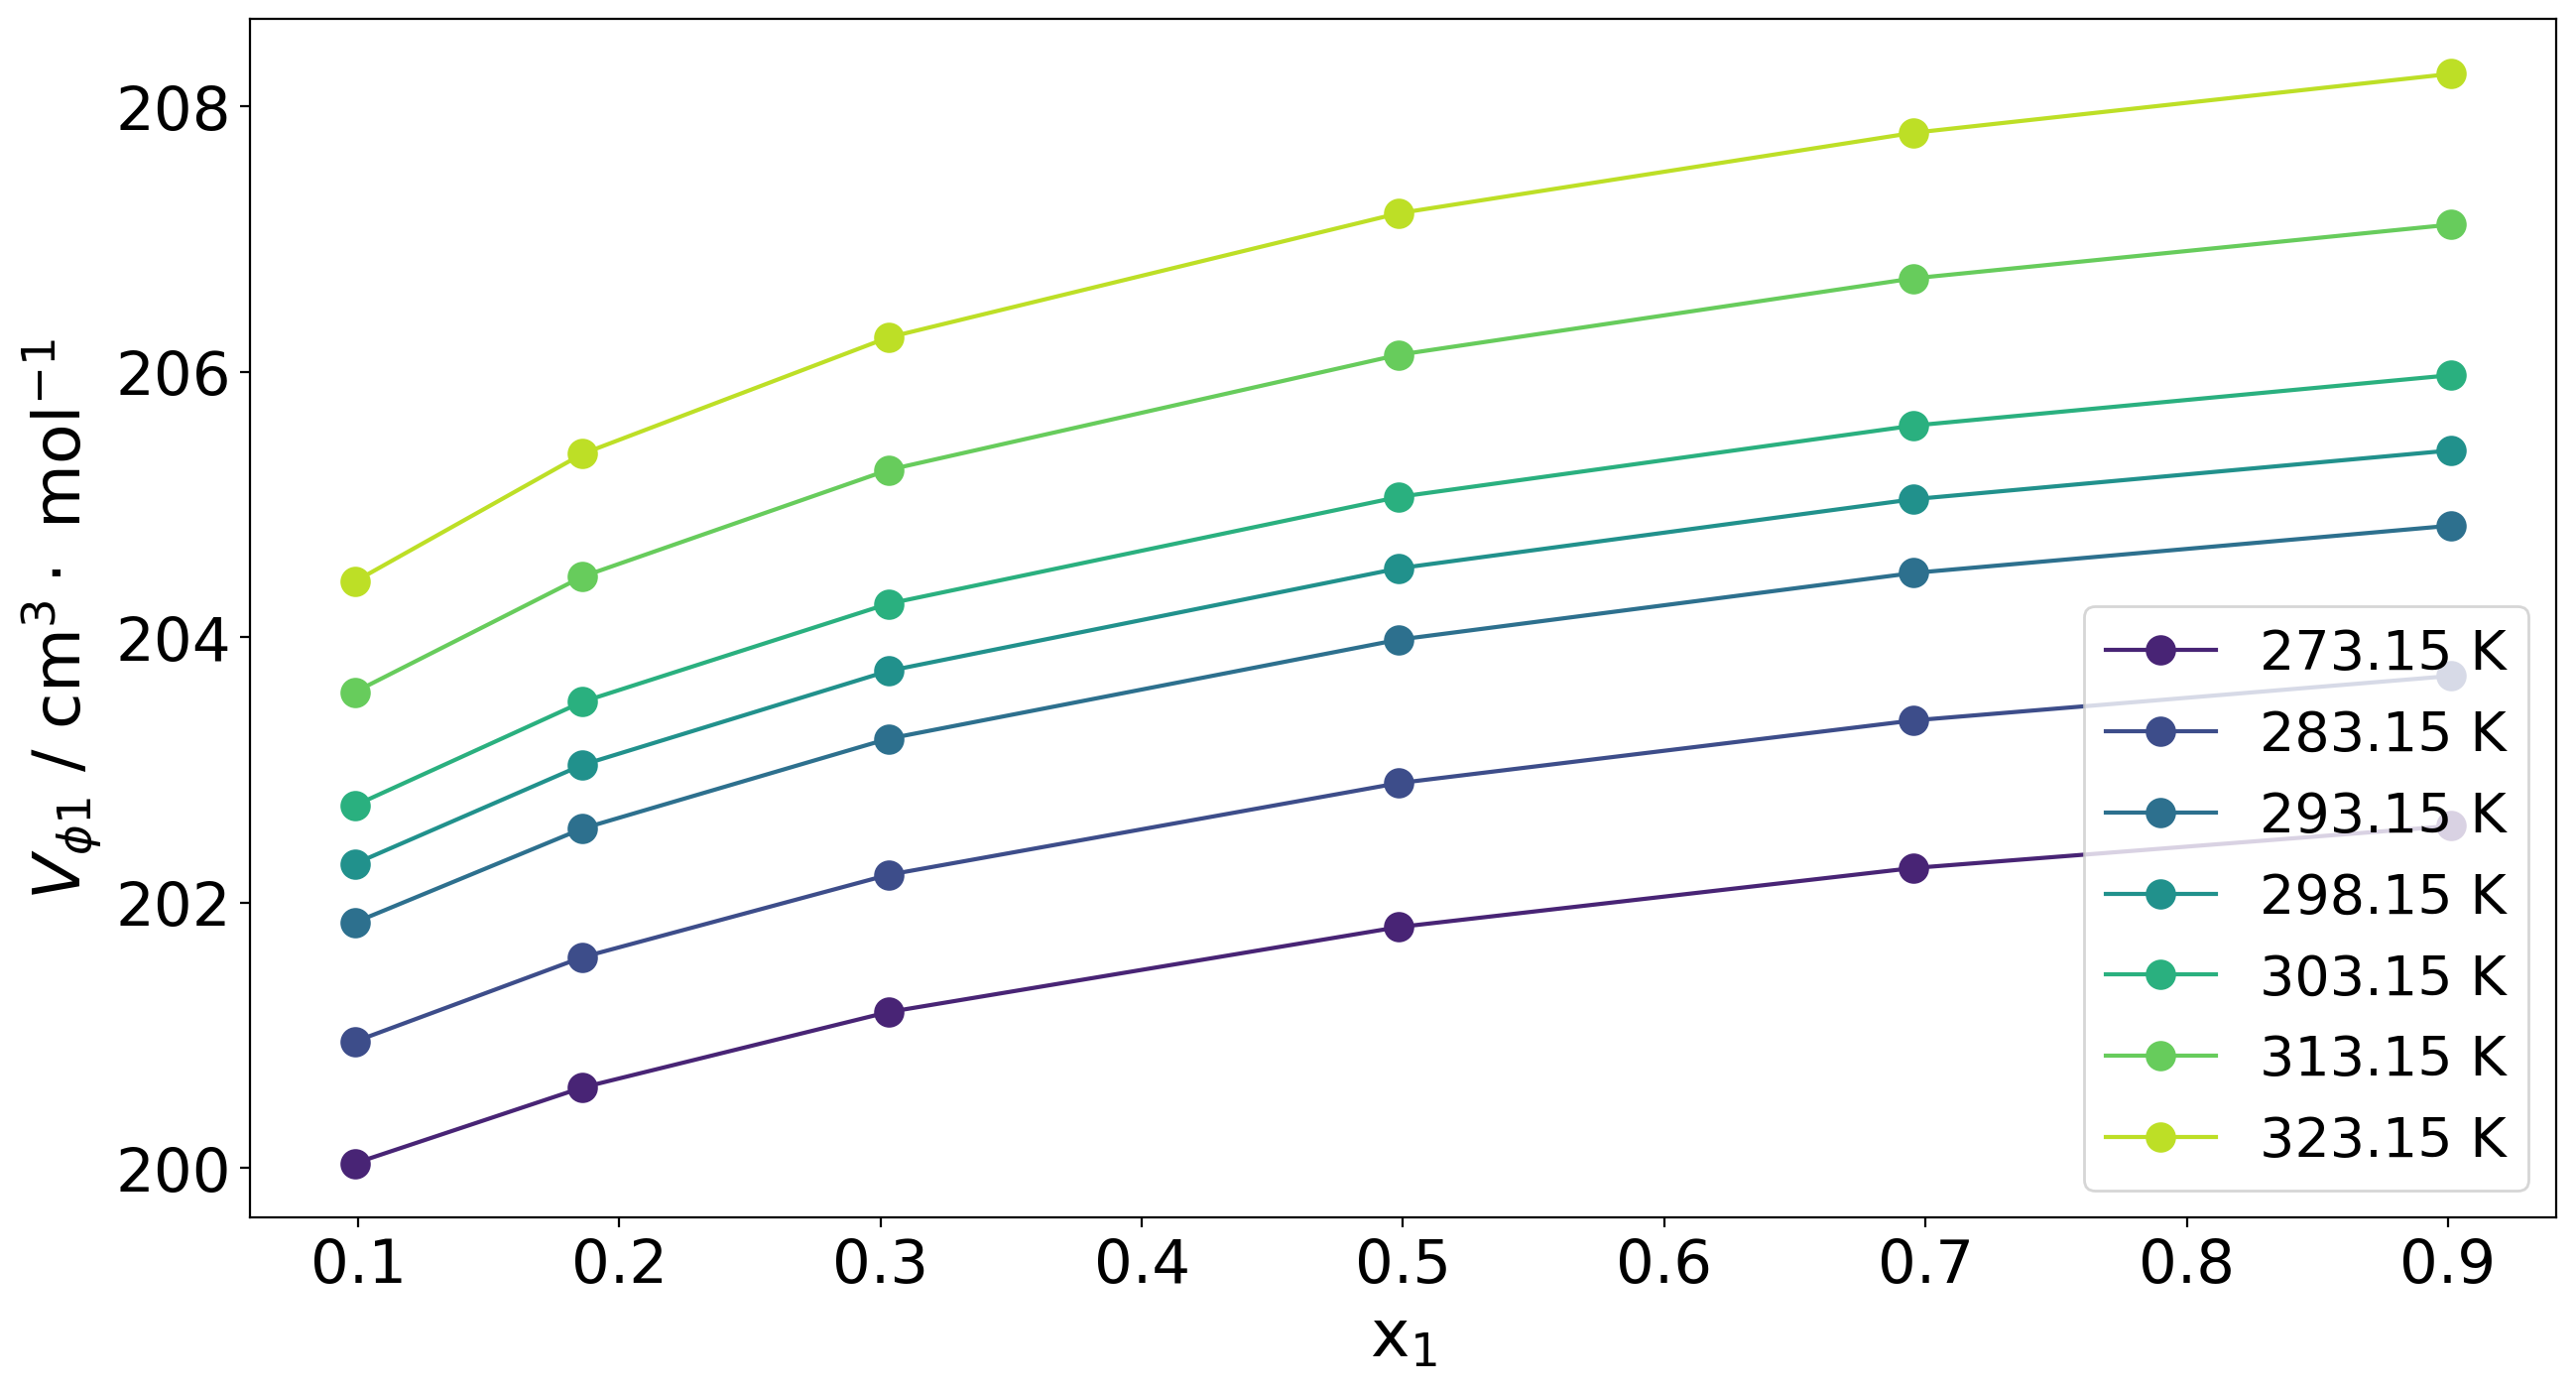

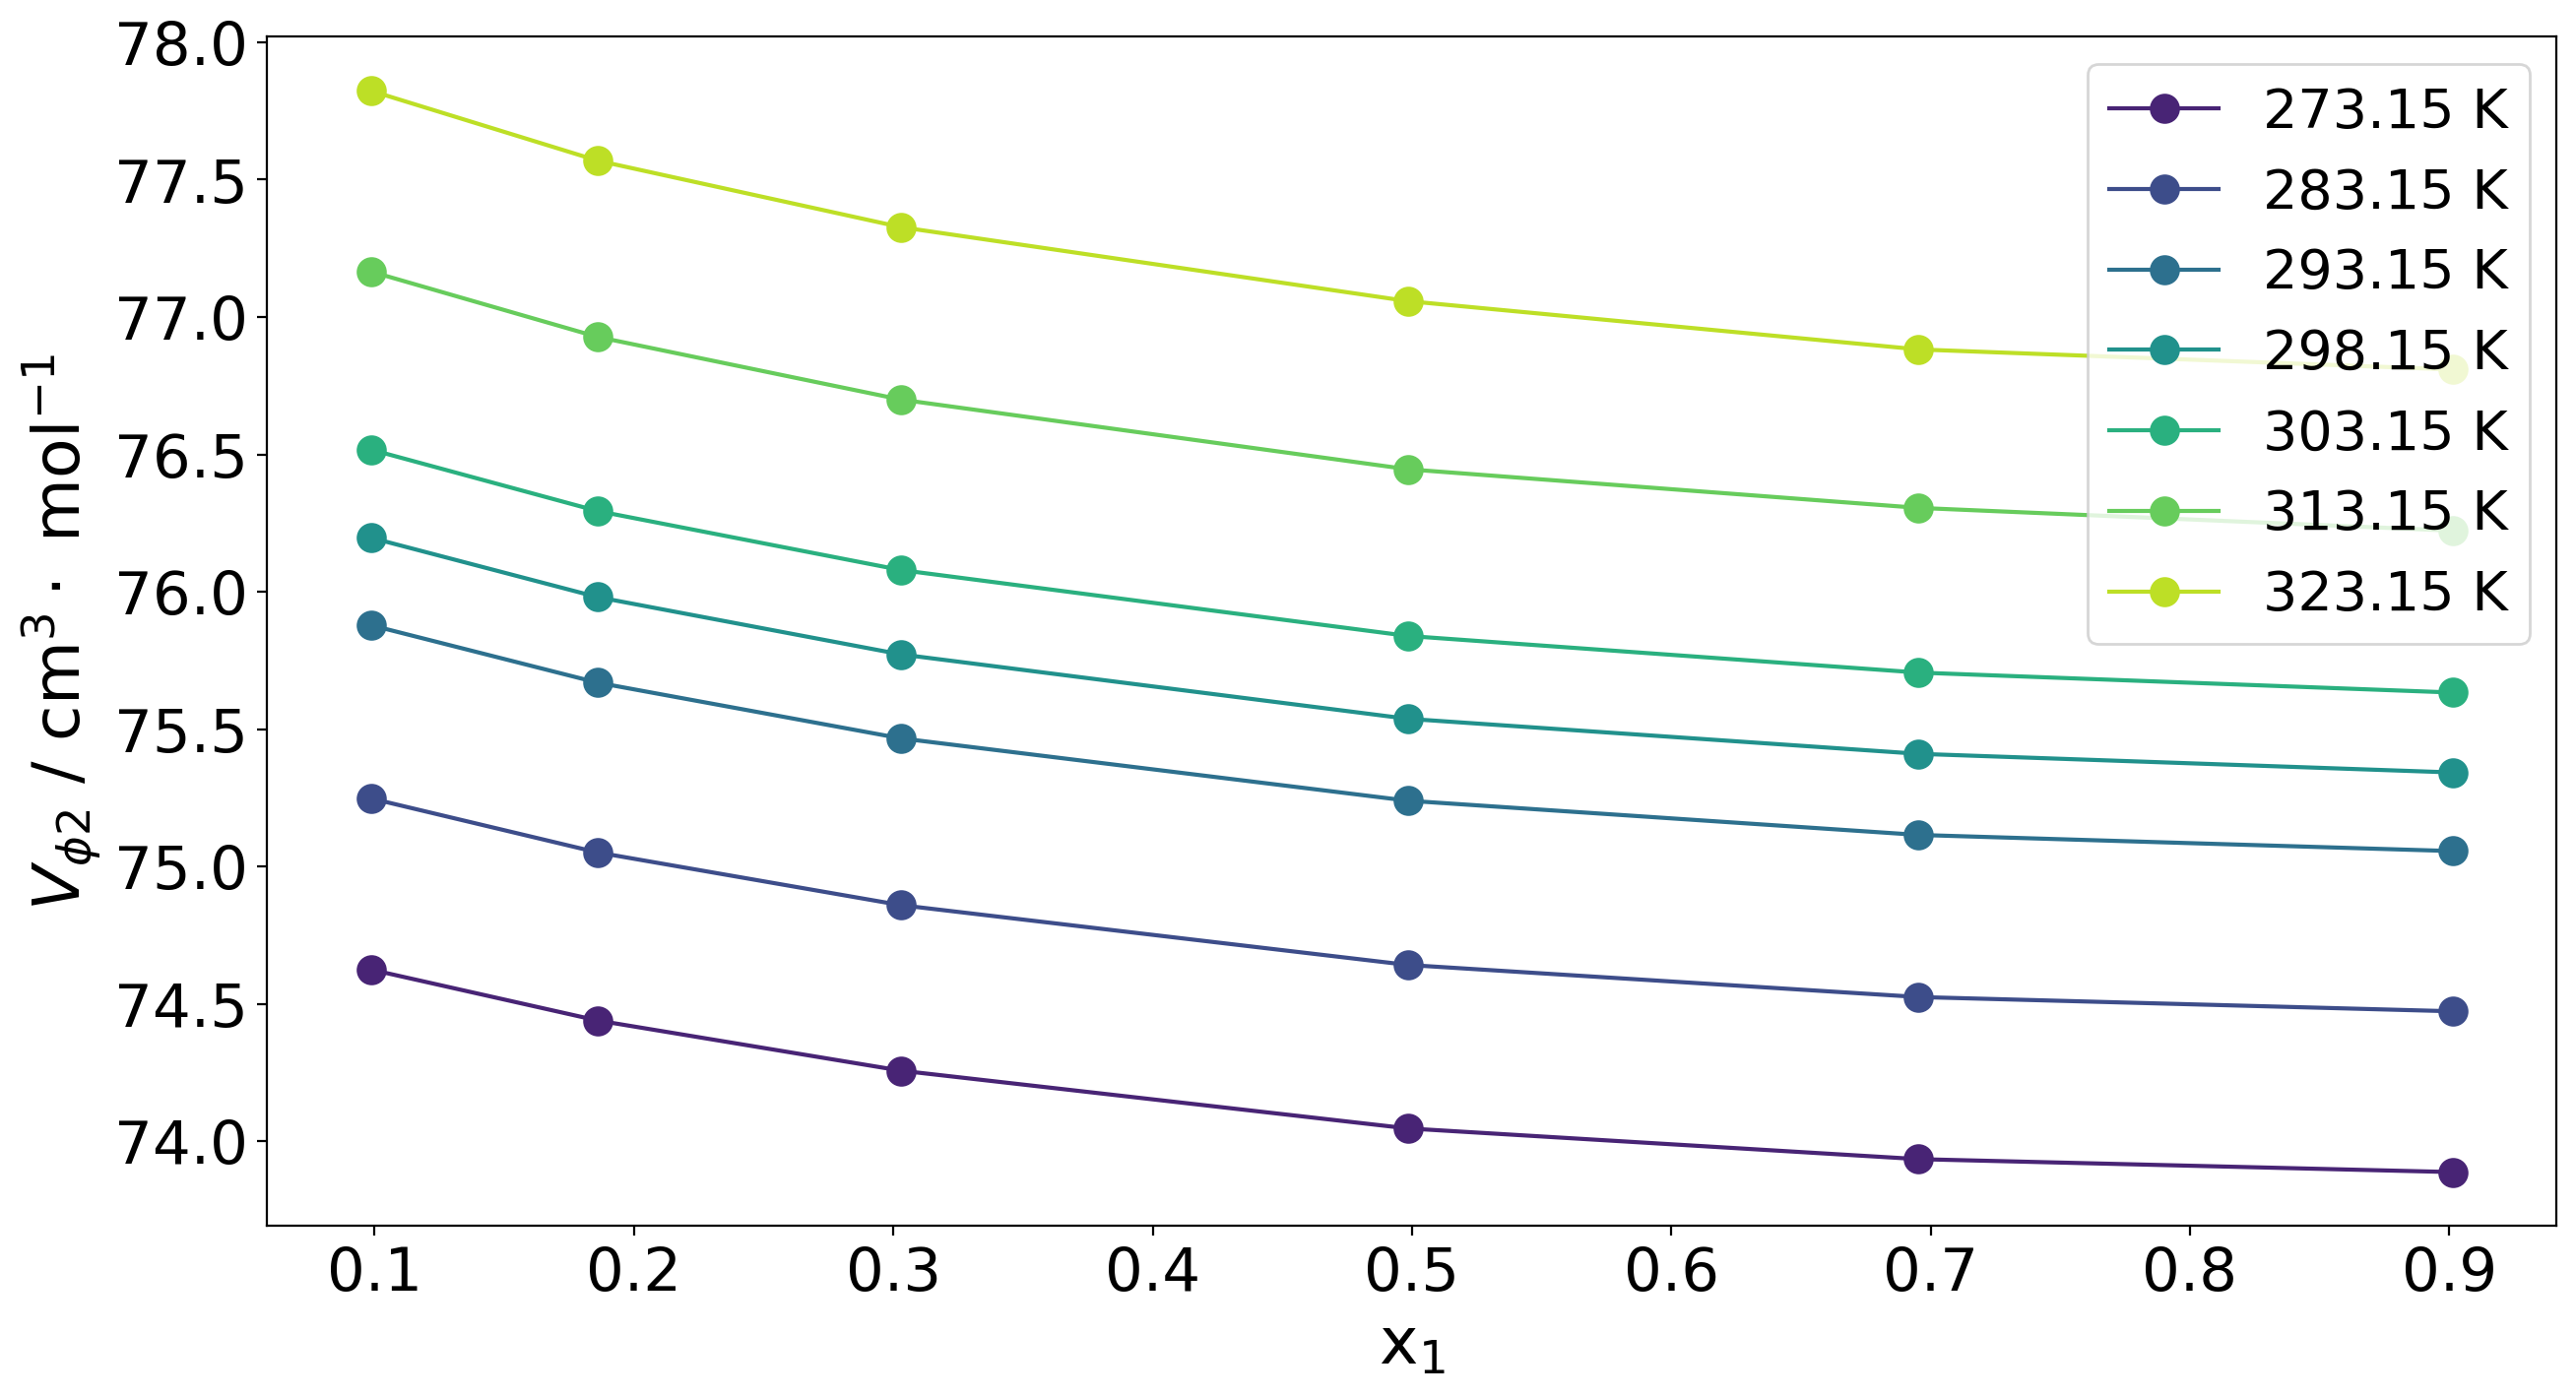

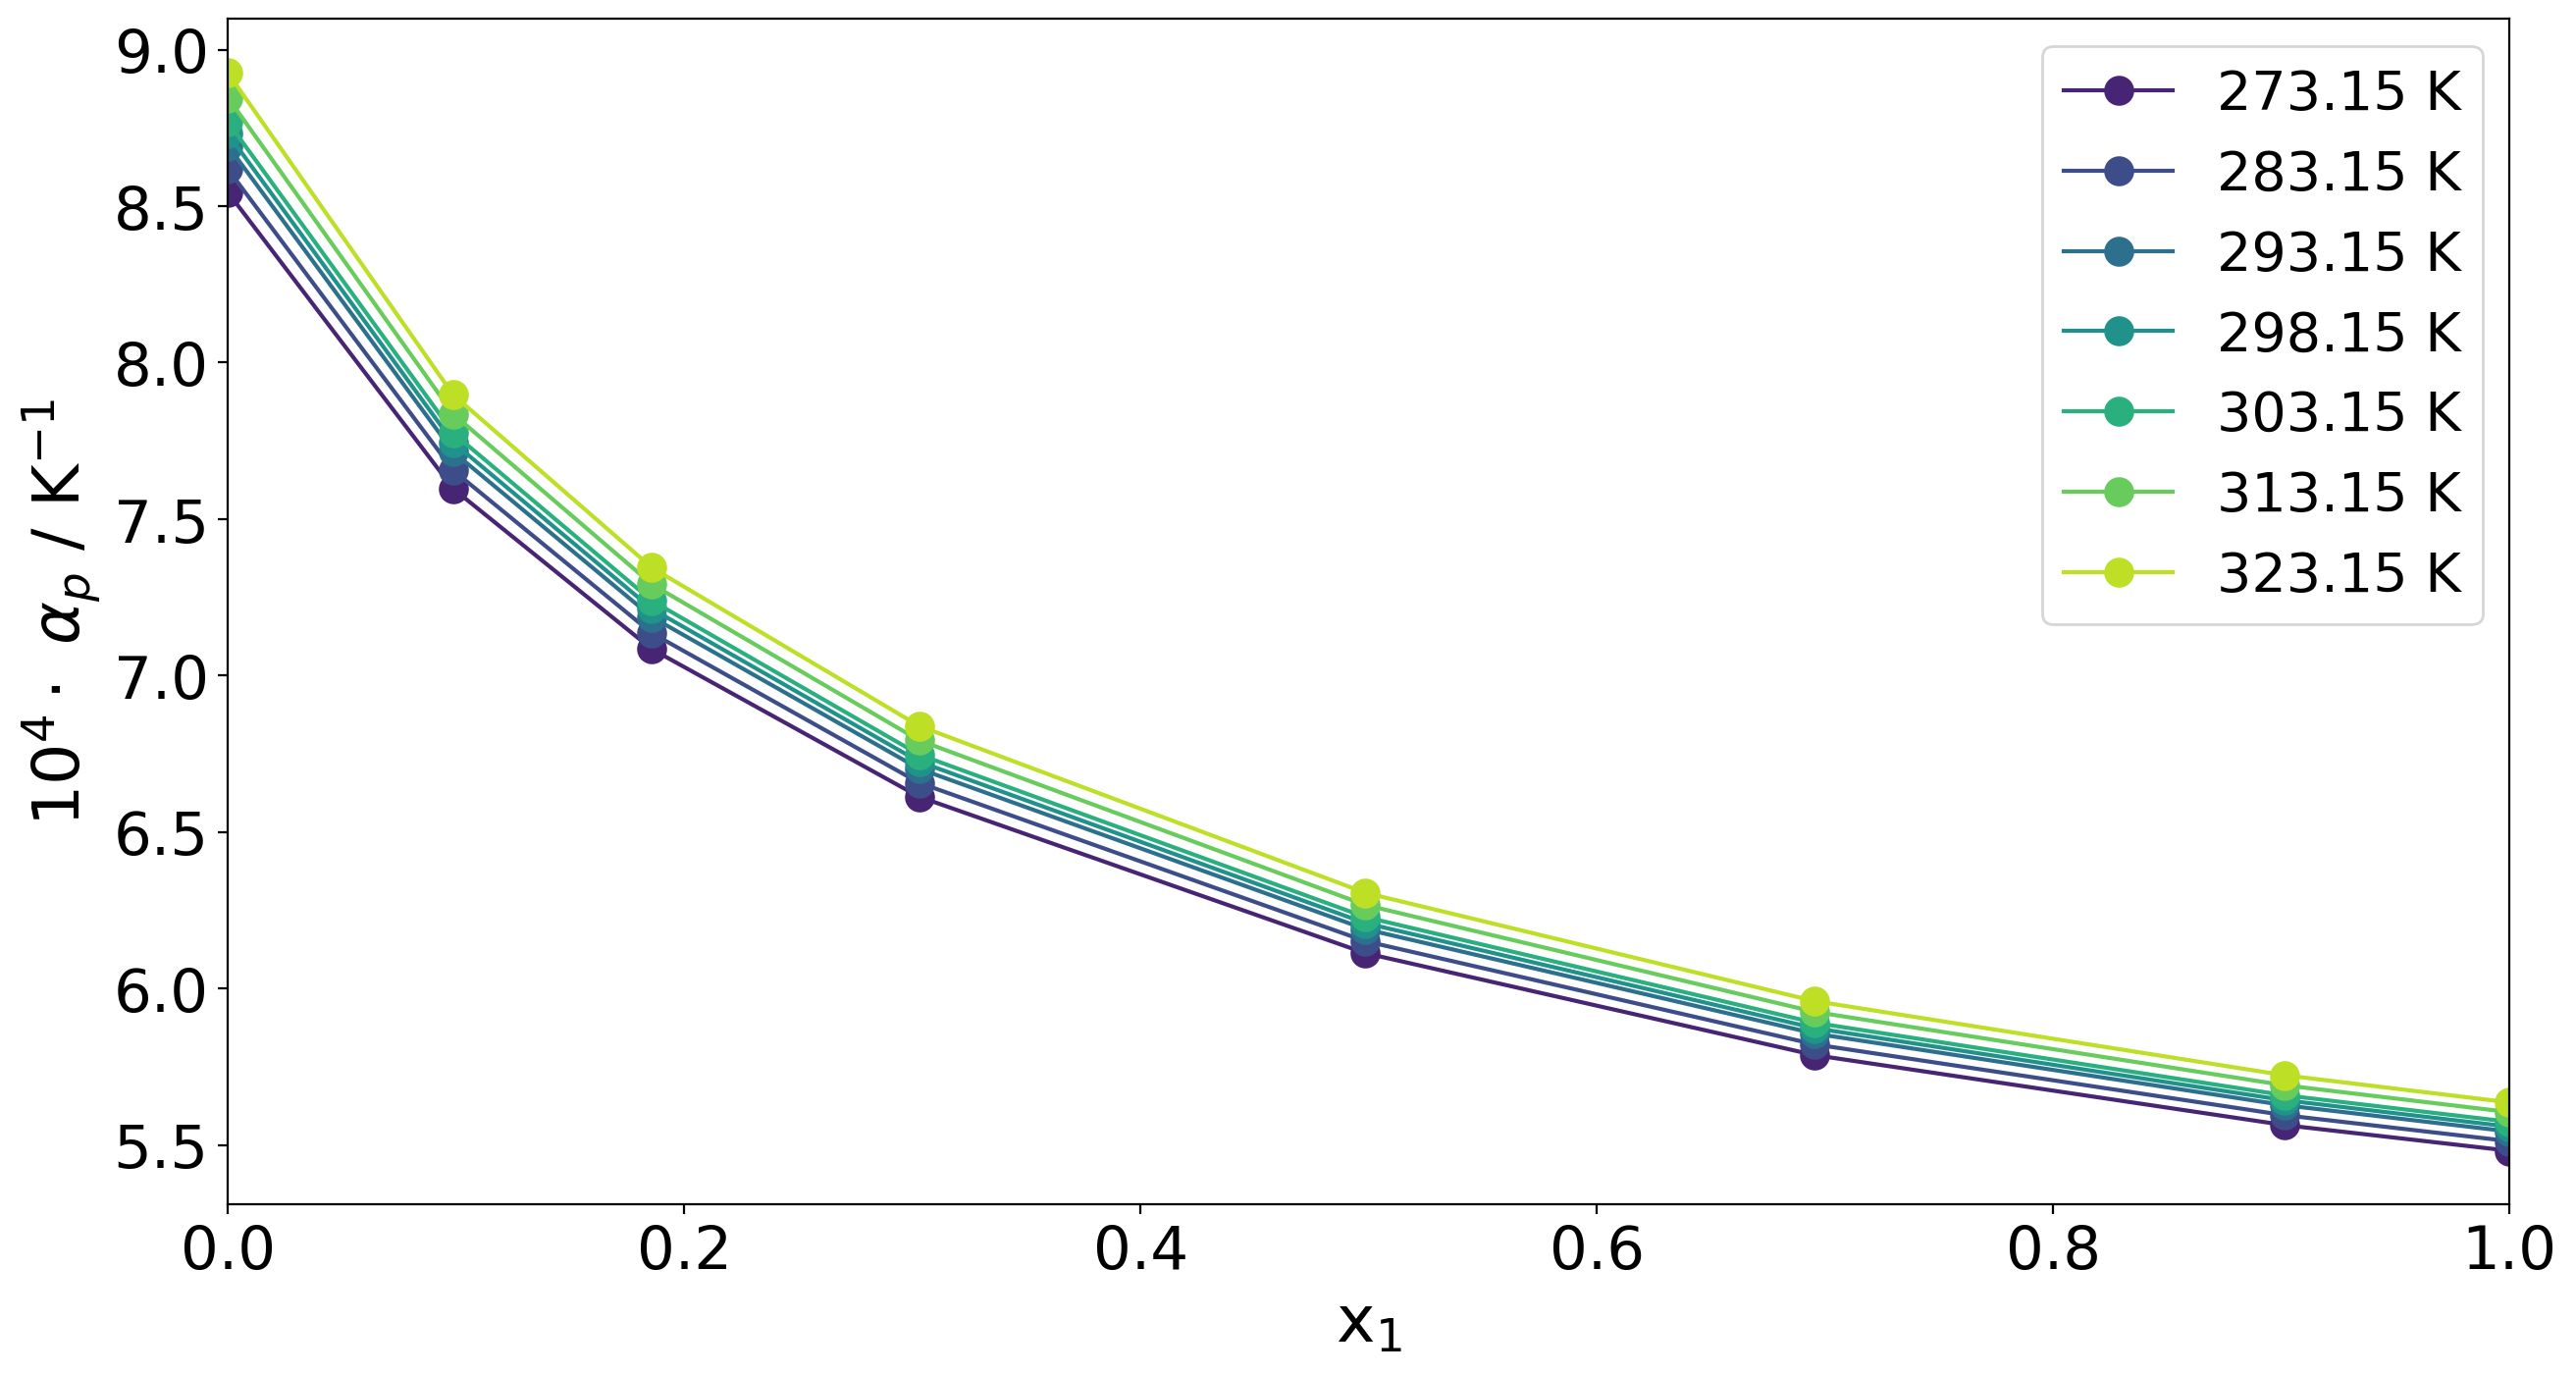

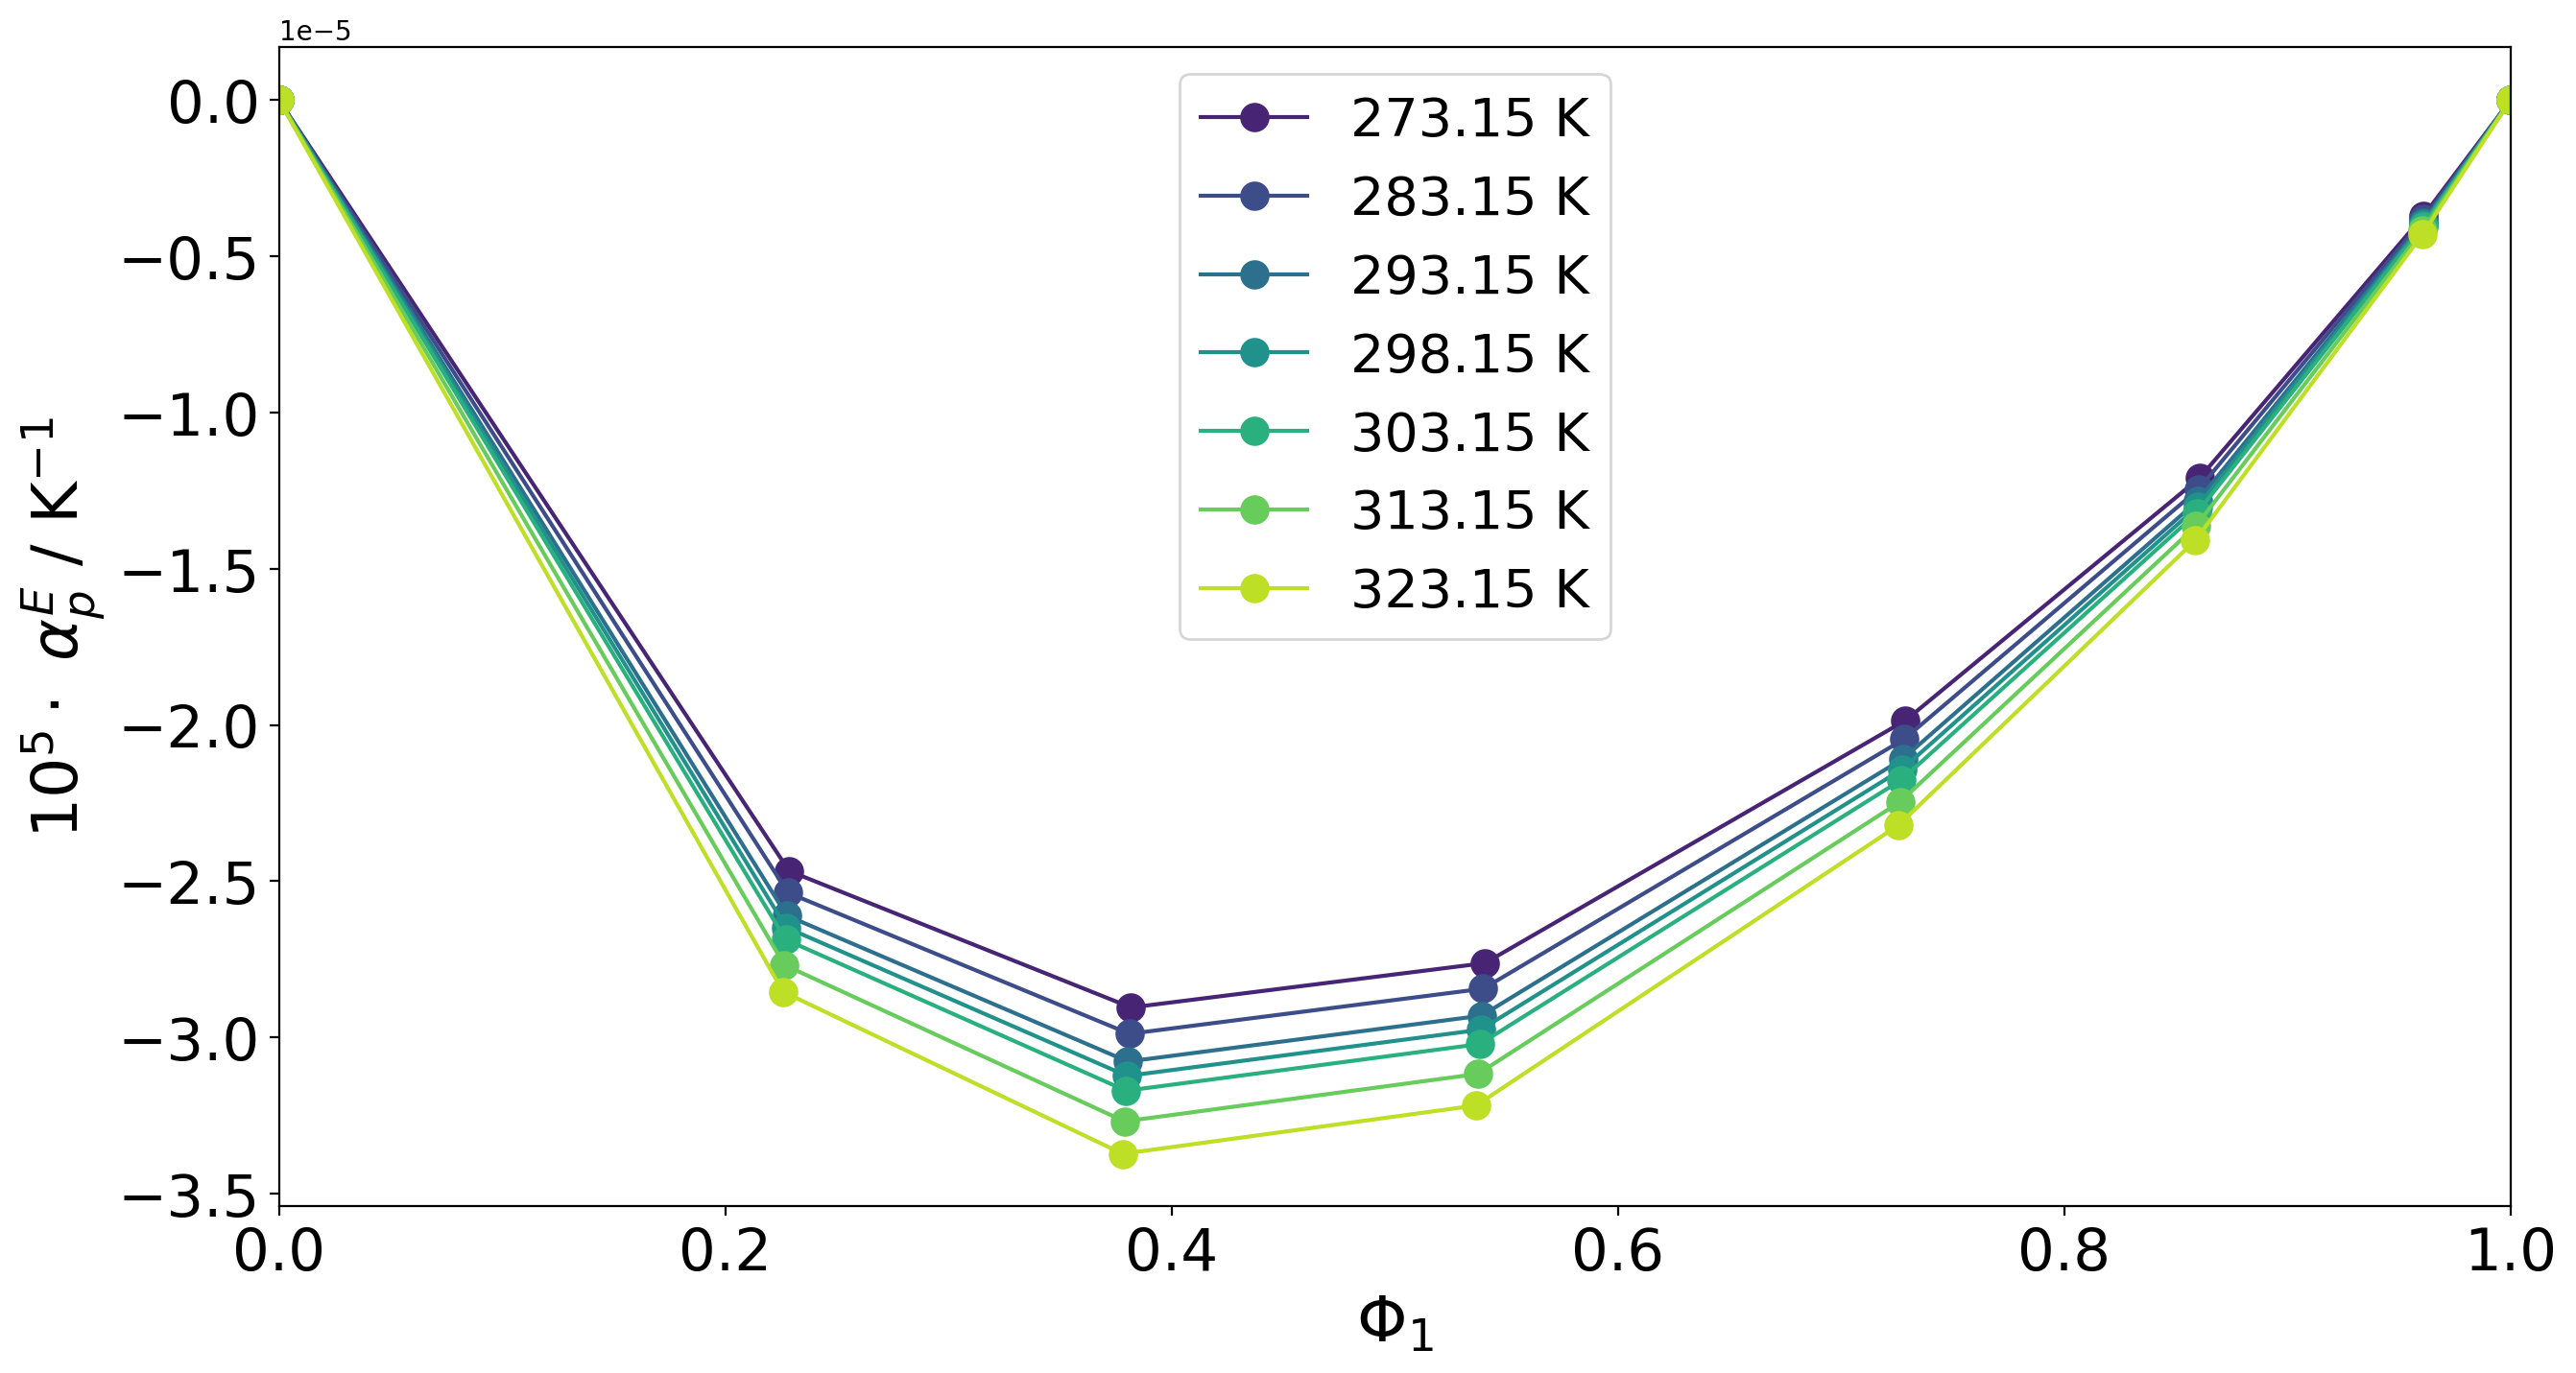

In [219]:
n = len(VE_fit)
colors = plt.cm.viridis(np.linspace(0.1,0.9,n))

plt.figure(figsize=(15, 8), dpi=200)
for i,j in zip(Ve.keys(),range(n)):
    plt.plot(x1, Ve[i], 'o', color=colors[j], markersize=10, label=i[3:])
for i, j in zip(VE_fit, range(n)):
    plt.plot(x_fit, i, '-', color=colors[j])
    plt.xlim(0,1)
        
plt.xticks(fontsize=22)
plt.xlabel('x$_1$', fontsize=24)
plt.yticks(fontsize=22)
plt.ylabel('$V^\mathrm{E}$ / cm$^3\cdot$ mol$^{-1}$', fontsize=24)
plt.legend(loc='upper center', fontsize=20)
plt.show()

#Plot the data

plt.figure(figsize=(15, 8), dpi=200)
for i,j,k in zip(V1_part,range(n), Ve.keys()):
    plt.plot(x1, i, 'o-', color=colors[j], markersize=10, label=k[3:])    

plt.xticks(fontsize=22)
plt.xlabel('x$_1$', fontsize=24)
plt.yticks(fontsize=22)
plt.ylabel('$V_\mathrm{1}$ / cm$^3\cdot$ mol$^{-1}$', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.show()    


plt.figure(figsize=(15, 8), dpi=200)
for i,j,k in zip(V2_part,range(n),Ve.keys()):
    plt.plot(x1, i, 'o-', color=colors[j], markersize=10, label=k[3:])    

plt.xticks(fontsize=22)
plt.xlabel('x$_1$', fontsize=24)
plt.yticks(fontsize=22)
plt.ylabel('$V_\mathrm{2}$ / cm$^3\cdot$ mol$^{-1}$', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.show()


print("APPARENT MOLAR VOLUMES")
plt.figure(figsize=(15, 8), dpi=200)
for i,j,k in zip(apparent_molar_volumes_1,range(n),Ve.keys()):
    plt.plot(x1[1:-1], i, 'o-', color=colors[j], markersize=10, label=k[3:])    
    
plt.xticks(fontsize=22)
plt.xlabel('x$_1$', fontsize=24)
plt.yticks(fontsize=22)
plt.ylabel('$V_{\phi\mathrm{1}}$ / cm$^3\cdot$ mol$^{-1}$', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.show()

plt.figure(figsize=(15, 8), dpi=200)
for i,j,k in zip(apparent_molar_volumes_2,range(n),Ve.keys()):
    plt.plot(x1[1:-1], i, 'o-', color=colors[j], markersize=10, label=k[3:])    
    
plt.xticks(fontsize=22)
plt.xlabel('x$_1$', fontsize=24)
plt.yticks(fontsize=22)
plt.ylabel('$V_{\phi\mathrm{2}}$ / cm$^3\cdot$ mol$^{-1}$', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.show()

plt.figure(figsize=(15, 8), dpi=200)
for i,j,k in zip(therm_exp_coeff,range(n),Ve.keys()):
    plt.plot(x1, i*10000, 'o-', color=colors[j], markersize=10, label=k[3:])    
    plt.xlim(0,1)
    
plt.xticks(fontsize=22)
plt.xlabel('x$_1$', fontsize=24)
plt.yticks(fontsize=22)
plt.ylabel(r'10$^4\cdot$ $\alpha_p}}$ / K$^{-1}$', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.show()

#EXCESS THERMAL EXPANSION COEFFITIENTS
plt.figure(figsize=(15, 8), dpi=200)
for i,j,k,l in zip(excess_therm_exp_coeff,range(n),Ve.keys(), volume_fraction):
    plt.plot(l, i, 'o-', color=colors[j], markersize=10, label=k[3:])    
    plt.xlim(0,1)
    
plt.xticks(fontsize=22)
plt.xlabel('$\Phi_1$', fontsize=24)
plt.yticks(fontsize=22)
plt.ylabel(r'10$^5\cdot$ $\alpha_p^E}}$ / K$^{-1}$', fontsize=24)
plt.legend(loc='best', fontsize=20)
plt.show()

In [172]:
"Saving data to csv file"

if save_data_to_csv == "yes":
    with open('volumetric_properties.csv', 'w') as f:
        f.write('Densities\n')
    pd.DataFrame(data).to_csv('volumetric_properties.csv', mode='a')

    with open('volumetric_properties.csv', 'a') as f:
        f.write('Excess Molar Volumes\n')
    pd.DataFrame(Ve, index=x1).to_csv('volumetric_properties.csv', mode='a')
    
    with open('volumetric_properties.csv', 'a') as f:
        f.write('Correlation coefficients of the RK fits\n')
    pd.DataFrame(r_sq, columns = ['R^2'], index = data.columns[1:]).to_csv('volumetric_properties.csv', mode='a')
    
    with open('volumetric_properties.csv', 'a') as f:
        f.write('RK equation coefficients\n')
    cols = []
    for i in range(1,len(RK_parameters[0])+1):
        cols.append("A"+str(i))
    pd.DataFrame(RK_parameters, index = data.columns[1:], 
                 columns = cols).to_csv('volumetric_properties.csv', mode='a')
    
    with open('volumetric_properties.csv', 'a') as f:
        f.write('Partial Molar Volumes of the component 1 - V1\n')
    pd.DataFrame(np.transpose(V1_part), index=x1, columns = data.columns[1:]).to_csv('volumetric_properties.csv', mode='a')
    
    with open('volumetric_properties.csv', 'a') as f:
        f.write('Partial Molar Volumes of the component 2 - V2\n')
    pd.DataFrame(np.transpose(V2_part), index=x1, columns = data.columns[1:]).to_csv('volumetric_properties.csv', mode='a')
    
    with open('volumetric_properties.csv', 'a') as f:
        f.write('Apparent Molar Volumes of the component 1 - Vf1\n')
    pd.DataFrame(np.transpose(apparent_molar_volumes_1), index=x1[1:-1], columns = data.columns[1:]).to_csv('volumetric_properties.csv', mode='a')
   
    with open('volumetric_properties.csv', 'a') as f:
        f.write('Apparent Molar Volumes of the component 2 - Vf2\n')
    pd.DataFrame(np.transpose(apparent_molar_volumes_2), index=x1[1:-1], columns = data.columns[1:]).to_csv('volumetric_properties.csv', mode='a')
    
    with open('volumetric_properties.csv', 'a') as f:
        f.write('Thermal expansion coeffitients - \n')
    pd.DataFrame(np.transpose(therm_exp_coeff), index=x1, columns = data.columns[1:]).to_csv('volumetric_properties.csv', mode='a')
    
    with open('volumetric_properties.csv', 'a') as f:
        f.write('Excess thermal expansion coeffitients - \n')
    pd.DataFrame(np.transpose(excess_therm_exp_coeff), index=x1, columns = data.columns[1:]).to_csv('volumetric_properties.csv', mode='a')
    
    
    
else:
    print("No data was saved to .csv file. Change save_data_to_csv = \"yes\" to save the data")